In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lfw-dataset/mismatchpairsDevTrain.csv
/kaggle/input/lfw-dataset/matchpairsDevTest.csv
/kaggle/input/lfw-dataset/pairs.csv
/kaggle/input/lfw-dataset/lfw_allnames.csv
/kaggle/input/lfw-dataset/peopleDevTest.csv
/kaggle/input/lfw-dataset/people.csv
/kaggle/input/lfw-dataset/peopleDevTrain.csv
/kaggle/input/lfw-dataset/mismatchpairsDevTest.csv
/kaggle/input/lfw-dataset/lfw_readme.csv
/kaggle/input/lfw-dataset/matchpairsDevTrain.csv
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Tyler_Hamilton/Tyler_Hamilton_0002.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Tyler_Hamilton/Tyler_Hamilton_0001.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Bernard_Siegel/Bernard_Siegel_0001.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Blythe_Danner/Blythe_Danner_0002.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Blythe_Danner/Blythe_Danner_0001.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Gen

# **Imports Libraries**

In [4]:
!pip install timm
import torch
from torch import nn
from timm import create_model
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# **Prepare Dataset**

# **split the data into training and test data.**

In [5]:
# Path to the dataset
Dataset = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

# Load all image paths and labels
all_image_paths = []
all_labels = []
for root, _, files in os.walk(Dataset):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            label = os.path.basename(root)
            all_image_paths.append(os.path.join(root, file))
            all_labels.append(label)

# Count the number of images per label
label_counts = Counter(all_labels)


# Simple random split without stratification
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42
)
print(f"Number of Classes : {len(label_counts)}")
print(f"Number of training samples: {len(train_paths)}")
print(f"Number of testing samples: {len(test_paths)}")



Number of Classes : 5749
Number of training samples: 10586
Number of testing samples: 2647


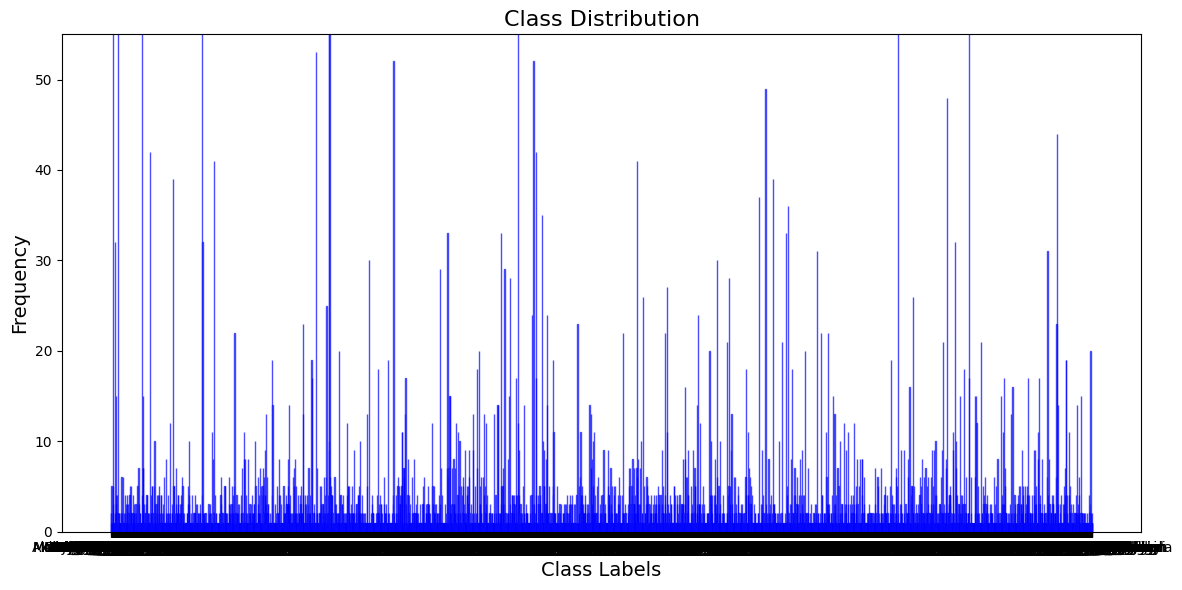

In [6]:
# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='lightblue', edgecolor='blue', alpha=0.7)
plt.ylim(0, 55)  # Limit the y-axis to the range of interest
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Class Distribution', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()


In [7]:
frequency_counts = Counter(label_counts.values())

for freq, count in sorted(frequency_counts.items()):
    print(f"Labels with frequency {freq}: {count}")
    # number of images : number of classes that have this number of images

Labels with frequency 1: 4069
Labels with frequency 2: 779
Labels with frequency 3: 291
Labels with frequency 4: 187
Labels with frequency 5: 112
Labels with frequency 6: 55
Labels with frequency 7: 39
Labels with frequency 8: 33
Labels with frequency 9: 26
Labels with frequency 10: 15
Labels with frequency 11: 16
Labels with frequency 12: 10
Labels with frequency 13: 11
Labels with frequency 14: 10
Labels with frequency 15: 11
Labels with frequency 16: 3
Labels with frequency 17: 8
Labels with frequency 18: 5
Labels with frequency 19: 7
Labels with frequency 20: 5
Labels with frequency 21: 4
Labels with frequency 22: 5
Labels with frequency 23: 3
Labels with frequency 24: 3
Labels with frequency 25: 1
Labels with frequency 26: 2
Labels with frequency 27: 1
Labels with frequency 28: 2
Labels with frequency 29: 2
Labels with frequency 30: 2
Labels with frequency 31: 2
Labels with frequency 32: 3
Labels with frequency 33: 3
Labels with frequency 35: 1
Labels with frequency 36: 1
Labels w

# **The highest 50 labels**

In [8]:
from collections import Counter
from sklearn.model_selection import train_test_split
import os

# Load all image paths and labels
all_image_paths = []
all_labels = []
for root, _, files in os.walk(Dataset):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            label = os.path.basename(root)
            all_image_paths.append(os.path.join(root, file))
            all_labels.append(label)

# Count the number of images per label
label_counts = Counter(all_labels)

# Get the top 50 labels with the highest image counts
top_labels = {label for label, count in label_counts.most_common(50)}

# Filter out invalid samples
filtered_image_paths = [path for path, label in zip(all_image_paths, all_labels) if label in top_labels]
filtered_labels = [label for label in all_labels if label in top_labels]

# Split the dataset into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    filtered_image_paths, filtered_labels, test_size=0.2, stratify=filtered_labels, random_state=42
)

# Print dataset sizes
print(f"Number of Classes : {len(top_labels)}")
print(f"Number of training samples: {len(train_paths)}")
print(f"Number of testing samples: {len(test_paths)}")

Number of Classes : 50
Number of training samples: 2218
Number of testing samples: 555


# **Data Generators**

In [9]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Define image data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Preprocess for Xception
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Preprocess for Xception
)

# Create TensorFlow data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(299, 299),  # Xception input size
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_paths, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(299, 299),  # Xception input size
    batch_size=64,
    class_mode='categorical'
)


Found 2218 validated image filenames belonging to 50 classes.
Found 555 validated image filenames belonging to 50 classes.


In [10]:
# Load Xception model without top layers
base_model = tf.keras.applications.Xception(
    weights='imagenet', include_top=False, input_shape=(299, 299, 3)
)
# Assuming 'model' is your Keras model
print(f"Number of layers in the model: {len(base_model.layers)}")

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the model: 132


# **Initial Setup and Freezing the Base Model**

In [11]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

# Open a strategy scope.
with strategy.scope():
    # Load Xception model without top layers
    base_model = tf.keras.applications.Xception(
        weights='imagenet', include_top=False, input_shape=(299, 299, 3)
    )
    
    # Freeze the base model to keep the pre-trained weights fixed during initial training
    base_model.trainable = False
    
    # Add custom layers on top of Xception
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(299, 299, 3)),  # Input layer
        base_model,  # Xception base model
        layers.GlobalAveragePooling2D(),  # Global pooling layer
        layers.Dense(512, activation='relu'),  # Custom dense layer
        layers.Dropout(0.5),  # Dropout to reduce overfitting
        layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer (number of classes)
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
model.summary()
# Assuming 'model' is your Keras model
print(f"Number of layers in the model: {len(model.layers)}")


Number of devices: 2


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,936,218 (83.68 MB)

 Trainable params: 1,074,738 (4.10 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Number of layers in the model: 5


# **Train the Model with Frozen Base Layers**

In [12]:
# clear cache
gc.collect()
torch.cuda.empty_cache()
# Train the model for the first few epochs with the base model frozen
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5
)


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.1602 - loss: 3.5924 - val_accuracy: 0.2158 - val_loss: 3.1591
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.2172 - loss: 3.1590 - val_accuracy: 0.2194 - val_loss: 3.0041
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2650 - loss: 2.9483 - val_accuracy: 0.2662 - val_loss: 2.7986
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2724 - loss: 2.8647 - val_accuracy: 0.2914 - val_loss: 2.7598
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3009 - loss: 2.7248 - val_accuracy: 0.3237 - val_loss: 2.5439


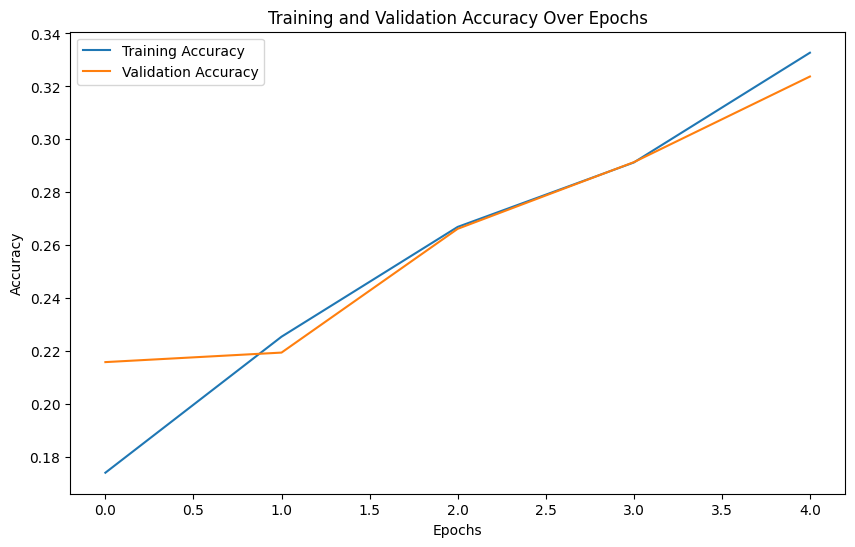

In [13]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history from model.fit()
# history = model.fit(...)

# Extract training and validation accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

# Add labels and title
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the evaluation results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.3212 - loss: 2.6370
Test Loss: 2.4846301078796387
Test Accuracy: 0.3741007149219513


In [15]:
# Assuming 'model' is your Keras model
print(f"Number of layers in the model: {len(model.layers)}")

Number of layers in the model: 5


# **Unfreeze Deeper Layers and Fine-Tune (100 layer)**

In [16]:
# Assuming `strategy` is already defined
with strategy.scope():
    # Unfreeze the last few layers of the base model
    base_model.trainable = True

    # Freeze the first 100 layers of Xception and unfreeze the rest
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Recompile the model after unfreezing layers (important step)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a smaller learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    #A good starting point is 5 epochs, adjusting based on the above factors.
    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    #Patience: You specify a "patience" value, which is the number of epochs to wait for improvement before stopping. If the validation metric doesn't improve for that many epochs, training stops.
    #Restore Best Weights: Optionally, the model can revert to the weights that achieved the best performance on the validation set.


    # Fine-tune the model with both the custom layers and the unfrozen Xception layers
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=150, # Max number of epochs
        callbacks=[early_stopping] # Include the callback here
    )
model.summary()


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.1413 - loss: 4.0399 - val_accuracy: 0.3633 - val_loss: 2.5794
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.1804 - loss: 3.6082 - val_accuracy: 0.3561 - val_loss: 2.5698
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2112 - loss: 3.3494 - val_accuracy: 0.3705 - val_loss: 2.4932
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2665 - loss: 3.0835 - val_accuracy: 0.3741 - val_loss: 2.5272
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2896 - loss: 2.9037 - val_accuracy: 0.3453 - val_loss: 2.6319
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.3028 - loss: 2.7811 - val_accuracy: 0.3777 - val_loss: 2.4643
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.3174 - loss: 2.7219 - val_accuracy: 0.4137 - val_loss: 2.3469
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.3505 - loss: 2.5663 - val_accuracy: 0.3741 - v

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,042,384 (164.19 MB)

 Trainable params: 10,553,082 (40.26 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

 Optimizer params: 21,106,166 (80.51 MB)

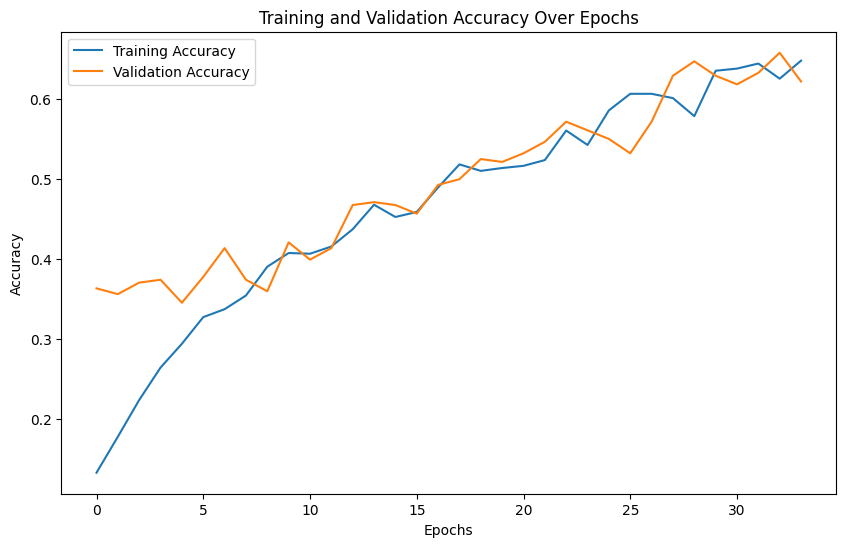

In [17]:
# Extract training and validation accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

# Add labels and title
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the evaluation results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 490ms/step - accuracy: 0.6297 - loss: 1.4269
Test Loss: 1.4338219165802002
Test Accuracy: 0.6366906762123108


# **Evaluation Metric Decisions**

In [26]:


# Get predictions and true labels
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)  # Predicted class indices
y_true = test_generator.classes           # True class indices

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step
                           precision    recall  f1-score   support

         Alejandro_Toledo       0.00      0.00      0.00         8
             Alvaro_Uribe       0.00      0.00      0.00         7
             Andre_Agassi       0.09      0.14      0.11         7
             Ariel_Sharon       0.04      0.06      0.05        16
    Arnold_Schwarzenegger       0.00      0.00      0.00         8
     Atal_Bihari_Vajpayee       0.00      0.00      0.00         5
             Bill_Clinton       0.00      0.00      0.00         6
             Colin_Powell       0.03      0.06      0.04        47
            David_Beckham       0.00      0.00      0.00         6
          Donald_Rumsfeld       0.07      0.08      0.08        24
            George_W_Bush       0.21      0.33      0.26       106
        Gerhard_Schroeder       0.04      0.05      0.04        22
  Gloria_Macapagal_Arroyo       0.07      0.11      0.09         9
               Gray_Da

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


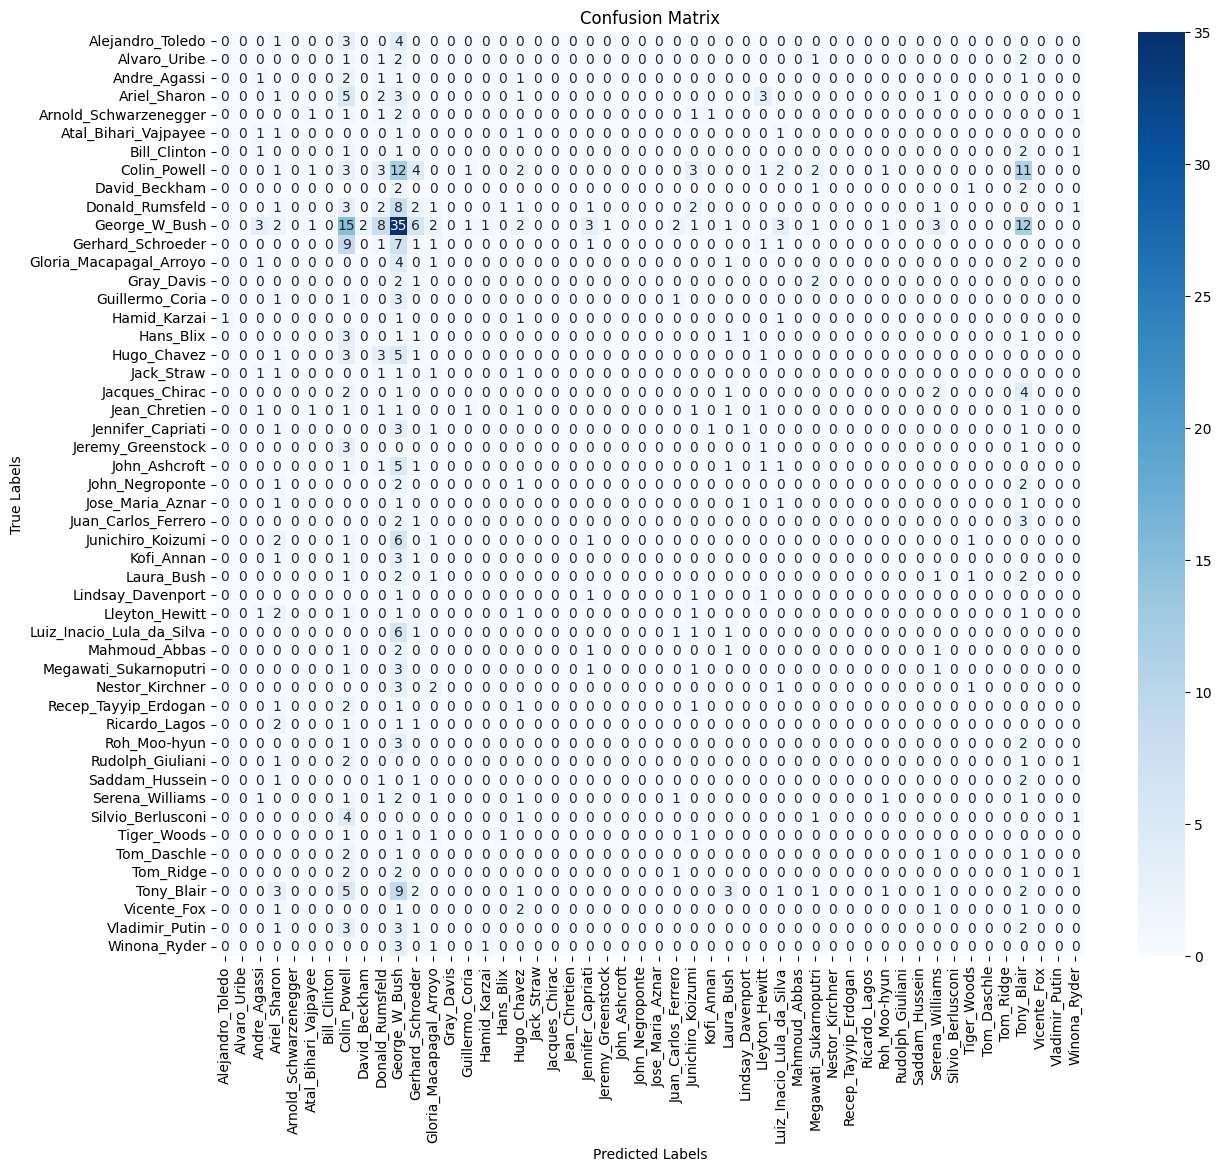

In [27]:
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step


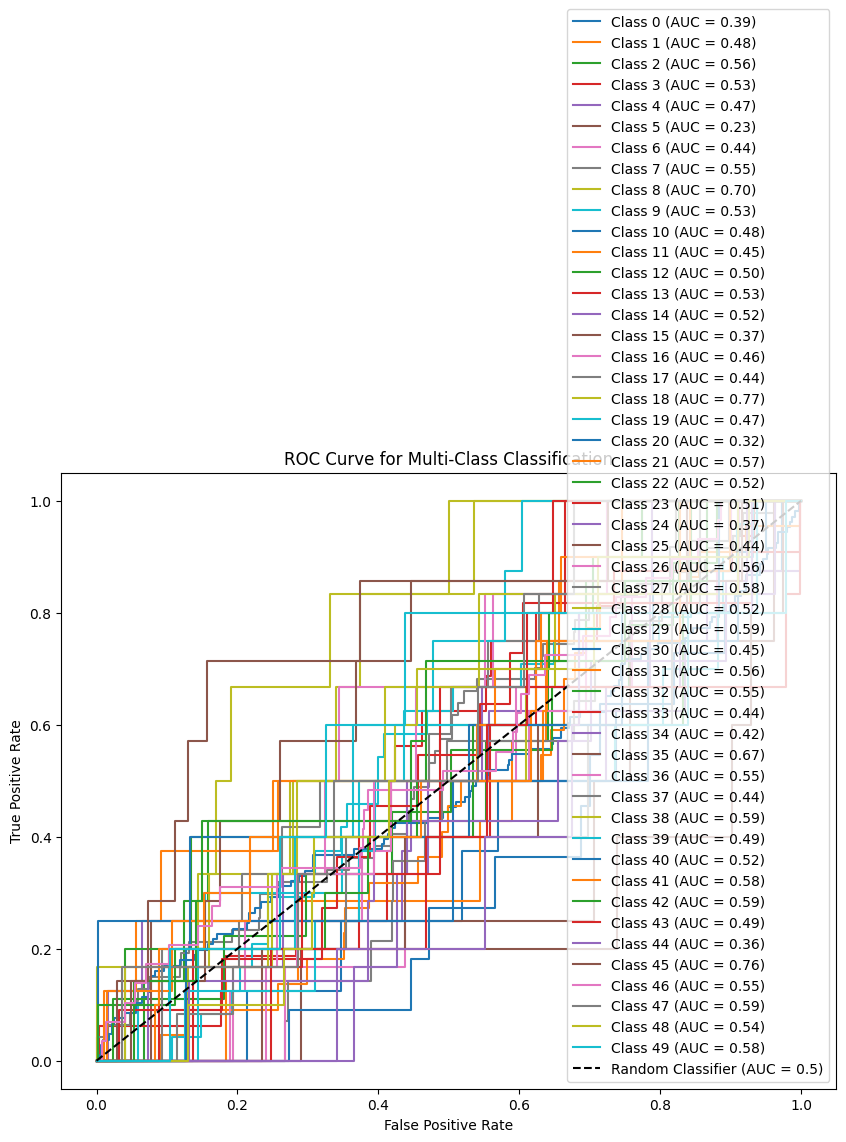

Class 0 AUC: 0.39
Class 1 AUC: 0.48
Class 2 AUC: 0.56
Class 3 AUC: 0.53
Class 4 AUC: 0.47
Class 5 AUC: 0.23
Class 6 AUC: 0.44
Class 7 AUC: 0.55
Class 8 AUC: 0.70
Class 9 AUC: 0.53
Class 10 AUC: 0.48
Class 11 AUC: 0.45
Class 12 AUC: 0.50
Class 13 AUC: 0.53
Class 14 AUC: 0.52
Class 15 AUC: 0.37
Class 16 AUC: 0.46
Class 17 AUC: 0.44
Class 18 AUC: 0.77
Class 19 AUC: 0.47
Class 20 AUC: 0.32
Class 21 AUC: 0.57
Class 22 AUC: 0.52
Class 23 AUC: 0.51
Class 24 AUC: 0.37
Class 25 AUC: 0.44
Class 26 AUC: 0.56
Class 27 AUC: 0.58
Class 28 AUC: 0.52
Class 29 AUC: 0.59
Class 30 AUC: 0.45
Class 31 AUC: 0.56
Class 32 AUC: 0.55
Class 33 AUC: 0.44
Class 34 AUC: 0.42
Class 35 AUC: 0.67
Class 36 AUC: 0.55
Class 37 AUC: 0.44
Class 38 AUC: 0.59
Class 39 AUC: 0.49
Class 40 AUC: 0.52
Class 41 AUC: 0.58
Class 42 AUC: 0.59
Class 43 AUC: 0.49
Class 44 AUC: 0.36
Class 45 AUC: 0.76
Class 46 AUC: 0.55
Class 47 AUC: 0.59
Class 48 AUC: 0.54
Class 49 AUC: 0.58


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming 'model' is your trained model, and 'test_generator' is your test dataset generator

# Get predictions and true labels
y_true = test_generator.classes  # True class indices
y_pred_proba = model.predict(test_generator, verbose=1)  # Predicted probabilities (not class indices)

# Number of classes
n_classes = len(test_generator.class_indices)

# Binarize the true labels for multi-class ROC curve computation
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

# Optionally: print AUC for each class
for i in range(n_classes):
    print(f'Class {i} AUC: {roc_auc[i]:.2f}')


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the image
img_path = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Tony_Blair/Tony_Blair_0016.jpg'

# Load the image with the required target size (Xception uses 299x299)
img = image.load_img(img_path, target_size=(299, 299))  # For Xception model

# Convert the image to a numpy array and preprocess
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (required by Keras)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # Preprocessing for Xception

# Make a prediction
predictions = model.predict(img_array)

# If the model is fine-tuned, you may have your own class labels.
# For example, if you have a list of class labels:
# class_labels = ['label_1', 'label_2', ..., 'label_19']  # Replace with your actual labels

# Get the index of the highest predicted class
predicted_class_idx = np.argmax(predictions)
print(predictions)

# Print the predicted class
print(f"Predicted class: {class_labels[predicted_class_idx]} with probability: {predictions[0][predicted_class_idx]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
[[1.0330846e-03 3.6020989e-03 2.6616277e-04 2.1719448e-04 4.7507118e-03
  4.5031928e-05 8.3200331e-04 3.9388803e-03 8.5891271e-04 5.4753758e-04
  1.6114190e-01 7.0983204e-03 1.8096363e-04 7.7115704e-04 5.1064999e-05
  2.9565346e-05 1.8760315e-03 1.0342600e-03 2.9113074e-03 1.5447076e-03
  2.1919480e-03 3.1031549e-04 6.8990735e-04 3.4849104e-03 5.9268228e-04
  9.4309408e-04 8.1827713e-04 1.0765697e-02 4.2622360e-05 3.3165391e-03
  2.4871211e-04 6.7681300e-05 5.0290843e-04 1.8810909e-04 2.4276215e-04
  2.7713894e-03 2.0903142e-03 1.1256710e-03 1.9182278e-03 1.5623514e-03
  1.0183351e-04 2.0278024e-04 2.2777019e-03 3.6164678e-05 4.5292435e-04
  1.2226084e-03 7.6262951e-01 3.9189244e-03 1.6474428e-03 9.0503832e-04]]
Predicted class: Tony_Blair with probability: 0.762629508972168


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to the image
img_path = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/George_W_Bush/George_W_Bush_0032.jpg'

# Load the image with the required target size (Xception uses 299x299)
img = image.load_img(img_path, target_size=(299, 299))  # For Xception model

# Convert the image to a numpy array and preprocess
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (required by Keras)
img_array = tf.keras.applications.xception.preprocess_input(img_array)  # Preprocessing for Xception

# Make a prediction
predictions = model.predict(img_array)

# If the model is fine-tuned, you may have your own class labels.
# For example, if you have a list of class labels:
# class_labels = ['label_1', 'label_2', ..., 'label_19']  # Replace with your actual labels

# Get the index of the highest predicted class
predicted_class_idx = np.argmax(predictions)

# Print the predicted class
print(f"Predicted class: {class_labels[predicted_class_idx]} with probability: {predictions[0][predicted_class_idx]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted class: George_W_Bush with probability: 0.9926031231880188
